In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()
import scipy.stats as stats

# Data

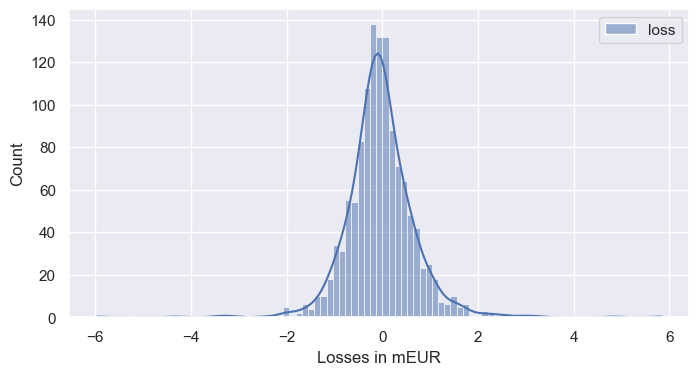

In [2]:
def load_data():
    losses = pd.read_excel('losses.xlsx').set_index('Date').rename(columns={0:'loss'}) / 1e6

    fig, ax = plt.subplots(figsize=(8,4))
    ax = sns.histplot(losses, kde=True, ax=ax)
    ax.set_xlabel("Losses in mEUR")

    return losses

losses = load_data()

---

# Block Maxima - Generalized Extreme Value distribution


**Notations of the course:**  
| Name | shape | cdf | pdf |
| :---  | :---  | :----: | :---: |
| Type I (Gumbel distribution)    | $k=0$ | $$H_0(x) = \exp (- e^{- x})$$                                                                    | $$h_0(x) = e^{- x}\exp (- e^{- x})$$ |
| Type II (Fréchet distribution)  | $k>0$ | $$H_k(x) = \begin{cases} 0 &1+k x < 0\\ \exp \bigl(-(1+k x)^{-\frac{1}{k}}\bigr) &1+k x > 0 \end{cases}$$  | $$h_k(x) = (1+k x)^{-\frac{1}{k}-1} \exp \bigl(-(1+k x\bigr)^{-\frac{1}{k}})$$ |
| Type III (Weibull distribution) | $k<0$ | $$H_k(x) = \begin{cases} \exp \bigl(-(1+k x)^{-\frac{1}{k}}\bigr)  &1+k x > 0\\ 1 &1+k x < 0 \end{cases}$$ | $$h_k(x) = \exp (- e^{- x})$$ |

**Variable name for `scipy.stats`:**  

`scipy.stats.genextreme(c)` where $c=-k$. Note the opposite sign.  

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html.  

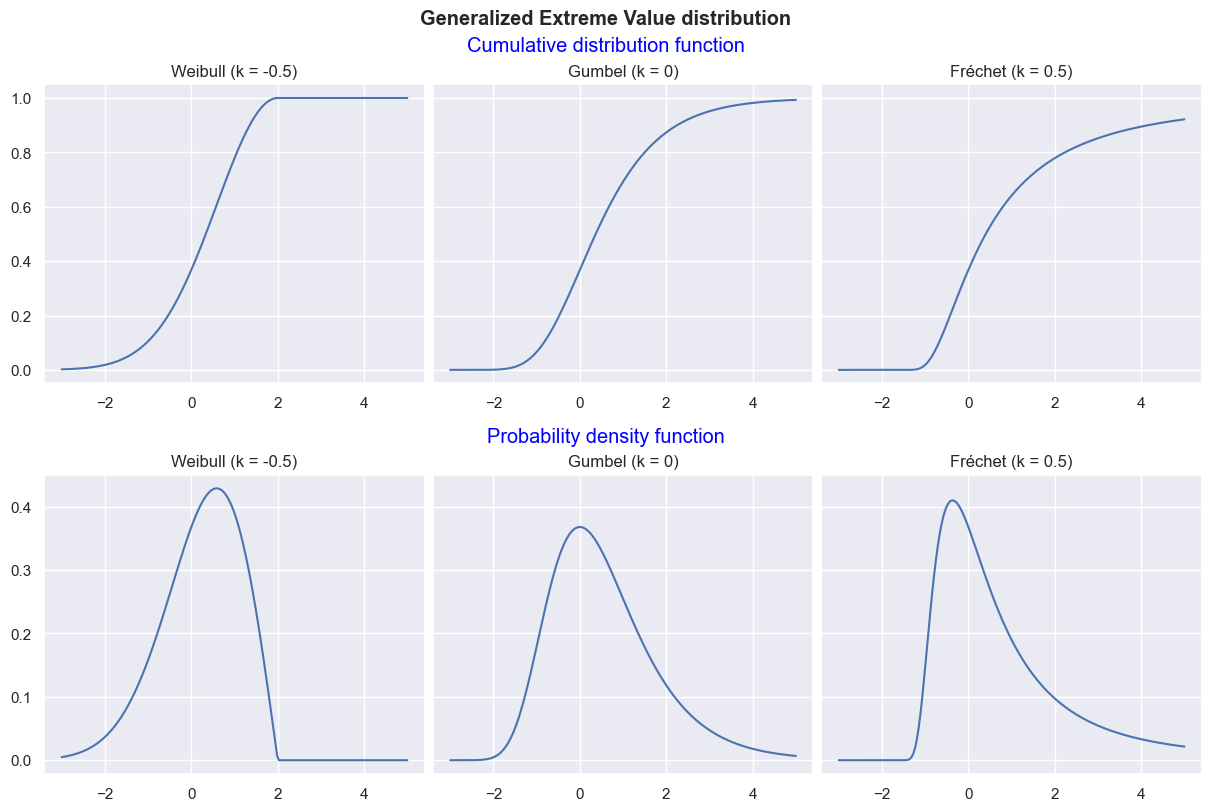

In [3]:
def plot_GEV(shape=0.5):
    params = [-shape, 0, shape]
    functions = {'cdf': "Cumulative distribution function", 'pdf': "Probability density function"}
    titles = ["Weibull", "Gumbel", "Fréchet"]
    x = np.linspace(-3, 5, 200)

    fig = plt.figure(figsize=(12,8), constrained_layout=True)
    fig.suptitle("Generalized Extreme Value distribution", fontweight='bold')
    subfigs = fig.subfigures(nrows=2, ncols=1)
    for subfig, fun in zip(subfigs, functions):
        subfig.suptitle(functions[fun], color='blue')
        axs = subfig.subplots(nrows=1, ncols=3, sharey=True)
        for ax, k, t in zip(axs, params, titles):
            if fun=='cdf':
                y = stats.genextreme.cdf(x,-k)
            elif fun=='pdf':
                y = stats.genextreme.pdf(x,-k)
            else:
                y = np.zeros_like(x)
            ax.plot(x, y)
            ax.set_title(t + f" (k = {k})")

plot_GEV()  

# Value-at-Risk with Block Maxima

## Extract the block maxima

Set the size of the blocks, compute the number of blocks and extract the losses which form these blocks

In [4]:
len(losses)

1258

In [5]:
10 / 3

3.3333333333333335

In [6]:
10 // 3

3

In [7]:
10 % 3

1

In [8]:
n = len(losses)
block_size = 21
n_blocks = n // block_size
losses_for_maxima = losses.iloc[-n_blocks*block_size:]
len(losses_for_maxima)==n_blocks*block_size

True

In [9]:
len(losses_for_maxima)

1239

Extract the maxima of each block

In [12]:
np.arange(10).reshape((5,2))

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [17]:
losses_for_maxima.values.reshape(n_blocks,block_size).shape

(59, 21)

In [18]:
maxima = losses_for_maxima.values.reshape(n_blocks,block_size).max(axis=1)

In [19]:
maxima

array([0.68981354, 0.53296397, 0.46189793, 0.99754954, 0.40312445,
       0.78190075, 1.08281851, 0.60572539, 0.74412266, 0.72152643,
       0.80764387, 0.48458909, 2.39112414, 5.82666591, 2.08904011,
       1.33087232, 2.12796978, 0.44501914, 1.60304462, 1.60514132,
       2.11853079, 0.91895085, 0.8889389 , 1.24180499, 1.79194922,
       1.11687236, 0.50878008, 1.4569287 , 0.64192985, 0.55408548,
       0.68082363, 1.428469  , 0.54052084, 0.92352976, 1.06124418,
       1.26303064, 1.46135314, 1.11703064, 1.71565715, 2.30979443,
       3.04150954, 0.65737239, 1.95710917, 2.55650269, 1.68655767,
       1.32670925, 1.42761063, 0.77907555, 1.48290204, 1.04358937,
       0.73986585, 0.77035829, 0.74298138, 1.12579391, 0.80939022,
       1.85383437, 1.20584039, 0.77495152, 0.86721929])

Obtain the positions of the maxima in the DataFrame

In [23]:
np.arange(10).reshape((2,5))

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [27]:
losses_for_maxima.values.reshape(n_blocks,block_size).argmax(axis=1)

array([14, 14,  7,  7, 16,  2,  2,  9,  5,  4,  1, 17, 18,  7,  0,  0,  7,
       10,  7,  3, 20,  7,  7, 18, 17,  1, 14,  7,  1, 10,  4, 19,  2, 16,
       14, 12,  3,  3, 20,  3,  8,  8, 18,  8,  5,  2,  3, 19, 13,  2,  8,
        9,  3, 16,  8, 13,  0,  6,  2])

In [26]:
maxima_index = losses_for_maxima.values.reshape(n_blocks,block_size).argmax(axis=1) + np.arange(n_blocks) * block_size

Plot the losses, blocks, and block maxima

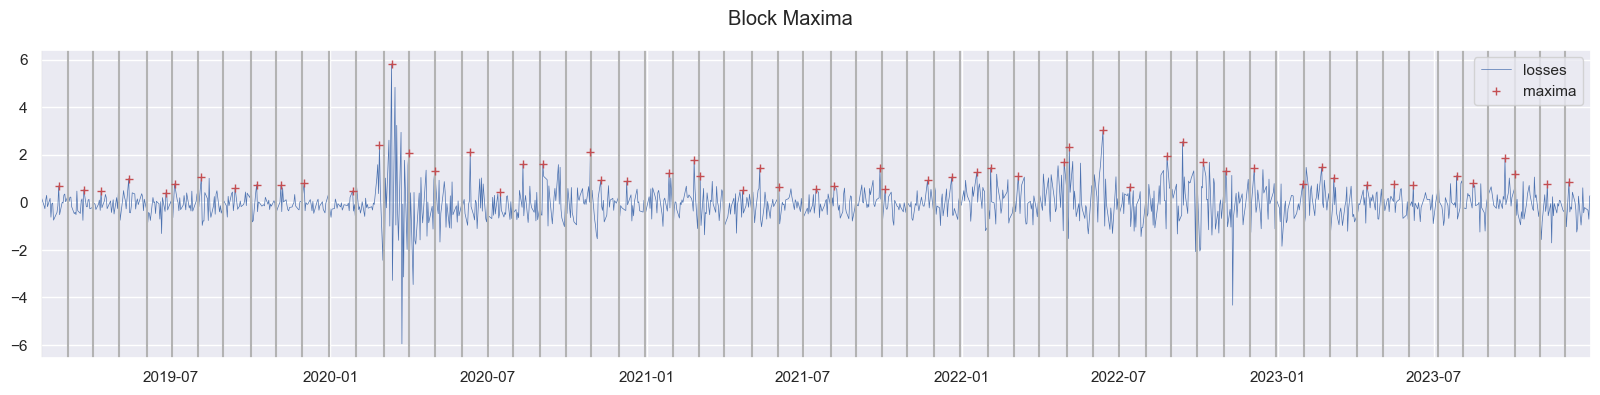

In [29]:
def plot_maxima(losses, max_idx):
    fig, ax = plt.subplots(figsize=(20,4))
    ax.plot(losses, lw=0.5, label="losses")
    for i in range(n_blocks):
        ax.axvline(losses.index[i*block_size], c='0.7')
    ax.plot(losses.iloc[max_idx], lw=0, marker='+', c='r', label="maxima")
    ax.set_xlim((losses.index[0], losses.index[-1]))
    ax.legend()
    fig.suptitle("Block Maxima")

plot_maxima(losses_for_maxima, maxima_index)

## Distribution of the block maxima

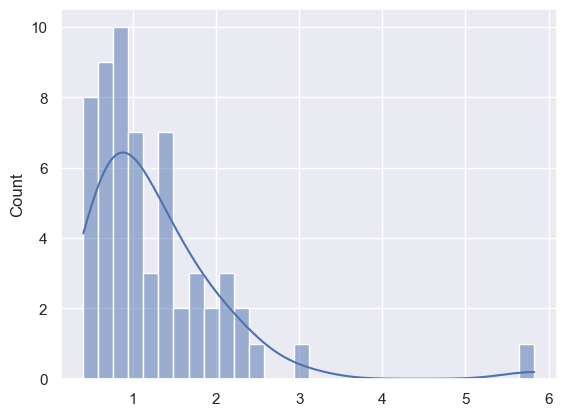

In [36]:
ax = sns.histplot(maxima, kde=True, bins=30)

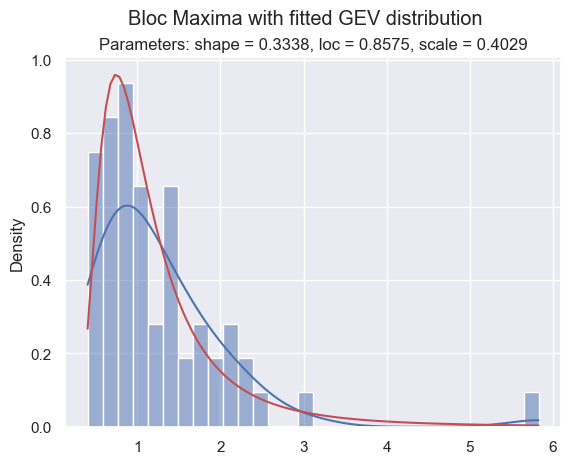

In [37]:
def fit_gev(data):
    k, loc, scale = stats.genextreme.fit(data)
    x = np.linspace(data.min(), data.max(), 100)

    fig, ax = plt.subplots()
    ax = sns.histplot(data, bins=30, kde=True, stat='density', ax=ax)
    ax.plot(x, stats.genextreme.pdf(x, k, loc, scale), c='r')
    fig.suptitle("Bloc Maxima with fitted GEV distribution")
    ax.set_title(f"Parameters: shape = {-k:.4f}, loc = {loc:.4f}, scale = {scale:.4f}", fontsize='medium')

    return k, loc, scale

k_gev, loc_gev, scale_gev = fit_gev(maxima)

## Estimation of Value-at-Risk

In [41]:
alpha=0.99
VaR_Maxima = stats.genextreme(k_gev, loc_gev, scale_gev).ppf(1-block_size*(1-alpha))
print(f"{alpha:.1%} Value-at-Risk computed with Nlock Maxima = {VaR_Maxima:.3f} mEUR")

99.0% Value-at-Risk computed with Nlock Maxima = 1.606 mEUR


---

# Threshold Exceedance - Generalized Pareto distribution

**Notations of the course:**  
$$
G_{k,\sigma}(x) = 
	\begin{cases}
    	1 - \left(1 + k \dfrac{x}{\sigma}\right)^{-1/k} & k \neq 0\\[2ex]
    	1 - \exp \left(- \dfrac{x}{\sigma}\right) & k = 0
	\end{cases}
\qquad
g_{k,\sigma}(x) = 
	\begin{cases}
		\dfrac{1}{\sigma} \left(1 + k \dfrac{x}{\sigma}\right)^{-\frac{1}{k}-1} & k \neq 0\\[2ex]
		\dfrac{1}{\sigma}  \exp \left(- \dfrac{x}{\sigma}\right) & k = 0
	\end{cases}
$$  
where $\sigma > 0$ and $x \geq 0$ when $k \geq 0$ and $0 \leq x \leq -\sigma/k$ when $k < 0$.  

**Variable name for `scipy.stats`:**  

`scipy.stats.genpareto(c)` where $c=k$.  
`scipy.stats.genpareto(c, loc, scale)` where $c=k$, `scale`=$\sigma$ and `loc`=$0$.  

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html.

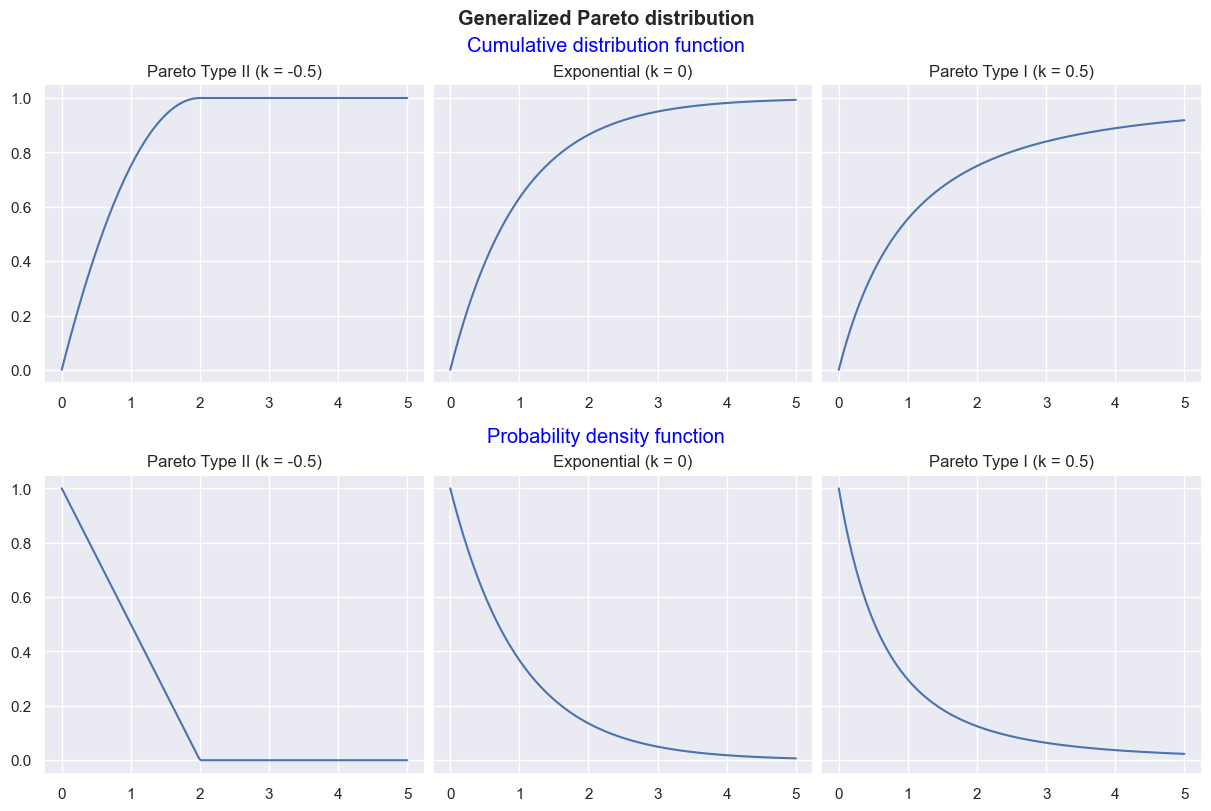

In [30]:
def plot_GPD(shape=0.5):
    params = [-shape, 0, shape]
    functions = {'cdf': "Cumulative distribution function", 'pdf': "Probability density function"}
    titles = ["Pareto Type II", "Exponential", "Pareto Type I"]
    x = np.linspace(0, 5, 200)

    fig = plt.figure(figsize=(12,8), constrained_layout=True)
    fig.suptitle("Generalized Pareto distribution", fontweight='bold')
    subfigs = fig.subfigures(nrows=2, ncols=1)
    for subfig, fun in zip(subfigs, functions):
        subfig.suptitle(functions[fun], color='blue')
        axs = subfig.subplots(nrows=1, ncols=3, sharey=True)
        for ax, k, t in zip(axs, params, titles):
            if fun=='cdf':
                y = stats.genpareto.cdf(x,k)
            elif fun=='pdf':
                y = stats.genpareto.pdf(x,k)
            else:
                y = np.zeros_like(x)
            ax.plot(x, y)
            ax.set_title(t + f" (k = {k})")

plot_GPD()

# Value-at-Risk with Threshold Exceedances

## Extract the Threshold Exceedances

Compute the threshold

In [31]:
u = losses['loss'].quantile(0.9)
print(f"Threshold = {u:.3f} mEUR")

Threshold = 0.742 mEUR


In [32]:
threshold_exceedances = losses[losses >= u].dropna() - u
n = len(losses)
n_u = len(threshold_exceedances)
print(f"Number of losses = {n}")
print(f"Number of threshold exceedances = {n_u}")

Number of losses = 1258
Number of threshold exceedances = 126


In [33]:
threshold_exceedances

,loss
Date,
2019-05-13,0.255656
2019-07-05,0.040007
2019-08-05,0.340925
2019-08-14,0.269326
2019-10-08,0.002229
...,...
2023-10-03,0.463947
2023-10-12,0.131545
2023-10-25,0.320544


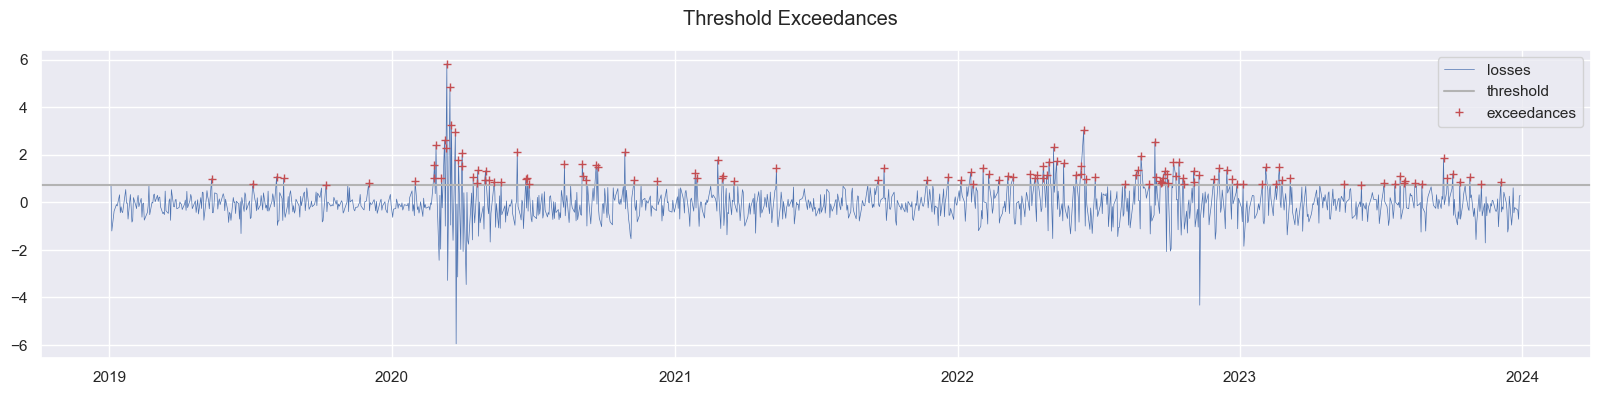

In [35]:
def plot_threshold_exceedances(data, threshold):
    fig, ax = plt.subplots(figsize=(20,4))
    ax.plot(data, lw=0.5, label="losses")
    ax.axhline(threshold, c='0.7', label="threshold")
    ax.plot(data[data >= threshold], lw=0, marker='+', c='r', label="exceedances")
    ax.legend()
    fig.suptitle("Threshold Exceedances")
    
plot_threshold_exceedances(losses, u)

## Distribution of the Threshold Exceedances

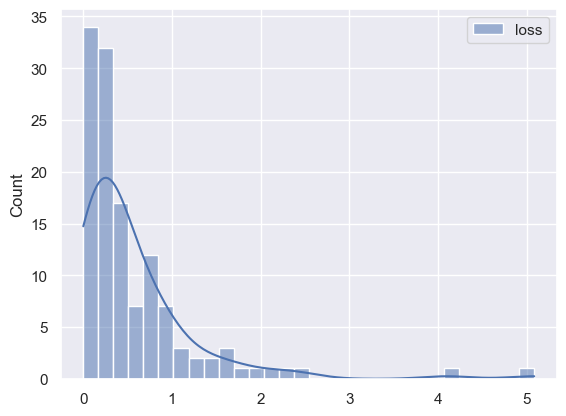

In [38]:
ax = sns.histplot(threshold_exceedances, kde=True, bins=30)

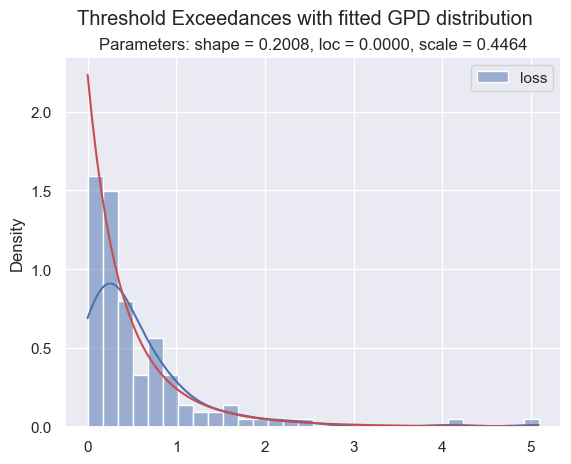

In [39]:
def fit_gpd(data):
    k, loc, scale = stats.genpareto.fit(data, floc=0)
    x = np.linspace(data.min(), data.max(), 100)
    
    fig, ax = plt.subplots()
    ax = sns.histplot(data, bins=30, kde=True, stat='density', ax=ax)
    ax.plot(x, stats.genpareto.pdf(x, k, loc, scale), c='r')
    fig.suptitle("Threshold Exceedances with fitted GPD distribution")
    ax.set_title(f"Parameters: shape = {k:.4f}, loc = {loc:.4f}, scale = {scale:.4f}", fontsize='medium')

    return k, loc, scale

k_gpd, loc_gpd, scale_gpd = fit_gpd(threshold_exceedances)

## Estimation of Value-at-Risk

In [42]:
alpha=0.99
VaR_Thr_Exc = u + scale_gpd/k_gpd * ((n/n_u*(1-alpha))**(-k_gpd)-1)
print(f"{alpha:.1%} Value-at-Risk computed with Threshold Exceedances = {VaR_Thr_Exc:.3f} mEUR")

99.0% Value-at-Risk computed with Threshold Exceedances = 2.050 mEUR
